In [1]:
import os
import sys
import numpy as np
from mpi4py import MPI

import triqs_modest as modest
from triqs.gf import MeshImFreq

import coqui
from coqui.utils.imag_axes_ft import IAFT
import coqui.embed.edmft.utils as edmft_helper

# Local utilities in TRIQS school materials
sys.path.append("./utils/")
import ctseg_solver

--------------------------------------------------------------------------
Ignoring value for oob_tcp_if_exclude on ccqlin065 (10.250.112.0/20: Did not find interface matching this subnet).
(You can safely ignore this message.)
--------------------------------------------------------------------------


Starting serial run at: 2025-08-31 17:29:13.690549


# 🔹 Toward Ab Initio GW+EDMFT
#### Context from previous notebooks:
You have already: 
1. Converted a DFT ground state to CoQuí/MLWFs ([01_dft_to_coqui_converter.ipynb](01_dft_to_coqui_converter.ipynb))
2. Run a GW calculation and obtained lattice G, Σ on a coarse k‑mesh and imaginary axis ([02_gw_electronic_structure.ipynb](02_gw_electronic_structure.ipynb))
3. Computed cRPA screened interactions $U(i\Omega_n)$ in the Wannier subspace via downfolding ([03_crpa_screened_interactions.ipynb](03_crpa_screened_interactions.ipynb)). 

#### New idea
In this notebook we will put these pieces together to construct an **ab initio impurity problem with dynamic interactions**, one step forward toward GW+EDMFT for real materials. This invovles thress stages:
1. Take lattice $G$ and $W$ from GW → form $G_{\mathrm{loc}}$ and $W_{\mathrm{loc}}$ in the Wannier subspace
2. Construct the fermionic and bosonic Weiss fiels $\mathcal{G}$, $\mathcal{U}$ from $G_{\mathrm{loc}}$ and $W_{\mathrm{loc}}$ to form the impurity action
3. Solve the impurity problem to obtain impurity self-energy $\Sigma_{\mathrm{imp}}$ and impurity polarizability $\Pi_{\mathrm{imp}}$

#### What you’ll learn:
1. How to construct an impurity problem with dynamic screened interactions 
2. How to solve the resulting impurity using TRIQS CT-SEG solver

## 🔹 Realizing GW+EDMFT: CoQuí × TRIQS Collaboration

<figure style="text-align: center;">
  <img src="./images/gw_edmft_workflow.png" alt="GW+EDMFT workflow using CoQuí + TRIQS" width="65%">
  <figcaption>GW+EDMFT workflow using CoQuí + TRIQS.</figcaption>
</figure>

The GW+EDMFT workflow shown in the figure above is realized through a close collaboration between **CoQuí** (orange boxes) and **TRIQS (ModEST + CT-SEG)** (blue boxes). Each framework takes on clearly defined responsibilities:

❓**Why do we need CoQuí?**  
1. Efficient **ab initio GW** with **full freqeuncy dependence** in the **complete Hilbert space**. 
2. Flexible **downfolding routines** to project lattice $G$ and $W$ into the MLWF subspace and **build the impurity action** for EDMFT.
3. Flexible **upfolding routines** to embed the impurity solution back into the full GW description. 

❓**Why do we need TRIQS-ModEST?**
1. Intuitive interface to **map MLWFs to the impurity subspace** used in EDMFT.
2. Supports **augmentation with multiple impurity sites**, essential for realistic materials with several correlated atoms.
3. Allows **block-structures and symmetry contraints** within an impurity, reducing computational cost and improving numerical stability.

Together, **CoQuí manages tasks in the complete basis** (GW calculation, downfolding, upfolding), while **TRIQS handles the steps that exclusively involve MLWFs** (constructing and solving the impurity model). 

## Test System: NiO - a paramagnetic charge-transfer insulator

<figure style="text-align: center;">
  <img src="./images/nio_gw_edmft_summary.png" alt="NiO" width="80%">
</figure>

Throughout this notebook, we will use **paramagnetic nickel oxide (NiO)** as a representative correlated material.

**What physics does NiO contain?**
- NiO is a classic **charge-transfer insulator**, where the gap arises from strong hybridization between Ni 3d and O 2p orbitals.
- The hybridization makes **double counting** a central **challenge in DFT+DMFT**.
- Both **DFT and GW** fail to capture the insulating state. 
- The insulating **Mott gap** opens primarily in the Ni e$_g$ orbitals and can only be described correctly by including **local correlations** through DMFT/EDMFT.

**Where do we start in this notebook?**
- We begin from a pre-computed self-consistent GW solution of NiO. 
- MLWFs were constructed from the DFT band structure within a large energy window covering both Ni $d$ and O $p$ states (8 MLWFs in total). The ordering of the MLWFs follows:
  1. Ni $e_{g}$ (2 orbitals),
  2. Ni $t_{2g}$ (3 orbitals),
  3. O $p$ (3 orbitals).

**What we will load:**
- `data/qe_inputs/nio/555/mlwf_dp/nio.mlwf.h5` → MLWFs for the Ni $d$ + O $p$ subspace
- `data/coqui/nio/555/nio.mbpt.h5` → pre-computed GW solution

**How will we proceed?**  
This notebook follows the Python script [04_gw_edmft.py](04_gw_edmft.py). We will split the script into **stages** reflceting the GW+EDMFT workflow introduced above and work through them one by one, with hands-on exercises at each stage: 
- **Stage 1: Downfolding to the MLWF subspace**  
  Take lattice $G$ and $W$ from GW → form $G_{\mathrm{loc}}$ and $W_{\mathrm{loc}}$ in the Wannier subspace
- **Stage 2: Impurity Problem with Dynamic Interactions**  
  Construct the fermionic and bosonic Weiss fiels $\mathcal{G}$, $\mathcal{U}$ from $G_{\mathrm{loc}}$ and $W_{\mathrm{loc}}$ to form the impurity action
- **Stage 3:  Solve the impurity problem**  
  Solve the impurity problem to obtain impurity self-energy $\Sigma_{\mathrm{imp}}$ and impurity polarizability $\Pi_{\mathrm{imp}}$

### 🎬 Hands-on 0: Initialization 

First let's setup a `Mf` for NiO Quantum ESPREESO outputs, and construct the THC Coulomb Hamiltonian. 

Execute the Python cell below, check the log to confirm:  
- the mean-field object was created from the QE outputs, and  
- the THC Coulomb Hamiltonian was successfully stored in `thc.coulomb.h5`. 

In [2]:
# --- Path for pre-generated inputs ---
mf_dir    = "data/qe_inputs/nio/555/out/"                 # QE outputs directory 
wan_h5    = "data/qe_inputs/nio/555/mlwf_dp/nio.mlwf.h5"  # MLWF file (8 orbitals for NiO)
coqui_dir = "data/coqui/nio/555/"                         # CoQuí checkpoint directory
coqui_h5  = "nio"                                         # CoQuí checkpoint with GW solution
thc_h5    = "data/coqui/nio/555/thc.coulomb.h5"           # THC Coulomb (optional: created if missing)

# Create CoQui MPI handler and set logging verbosity in the beginning 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

# --- Mf and THC Coulomb Hamiltonian for NiO ---
# Mean-field handler
mf_params = {
    "prefix": "nio", 
    "outdir": mf_dir, 
    "nbnd": 40
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe") 

# Coulomb Hamiltonian
thc_params = {
    "thresh": 1e-4, 
    "ecut": 60, 
    "save": thc_h5, 
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)

  Quantum ESPRESSO reader
  -----------------------
  Number of spins                = 1
  Number of polarizations        = 1
  Number of bands                = 40
  Monkhorst-Pack mesh            = (5,5,5)
  K-points                       = 125 total, 10 in the IBZ
  Number of electrons            = 24.0
  Electron density energy cutoff = 400.000 a.u. | FFT mesh = (36,36,36)
  Wavefunction energy cutoff     = 58.981 a.u. | FFT mesh = (19,19,19), Number of PWs = 2733


╔═╗╔═╗╔═╗ ╦ ╦╦  ╔╦╗┬ ┬┌─┐╔═╗┌─┐┬ ┬┬  ┌─┐┌┬┐┌┐ 
║  ║ ║║═╬╗║ ║║   ║ ├─┤│  ║  │ ││ ││  │ ││││├┴┐
╚═╝╚═╝╚═╝╚╚═╝╩   ╩ ┴ ┴└─┘╚═╝└─┘└─┘┴─┘└─┘┴ ┴└─┘

  Algorithm                       = ISDF
  THC integrals access            = incore
  Found precomputed THC integrals = false
  --> CoQuí will compute THC integrals and save to: data/coqui/nio/555/thc.coulomb.h5

  ERI::thc Computation Details
  ----------------------------
  Energy cutoff                = 60.0 a.u. | FFT mesh = (19,19,19), Number of PWs = 2733
  Threshold         

### ⬇️ Stage 1: Downfolding to the MLWF subspace (CoQuí)

<figure style="text-align: center;">
  <img src="./images/gw_edmft_downfold.png" alt="GW+EDMFT workflow - Downfolding" width="60%">
  <figcaption>GW+EDMFT workflow - Downfolding.</figcaption>
</figure>

The first stage corresponds to the **highlighted “downfold”** box in the workflow. Starting from the lattice GW quantities in the complete Bloch basis (or any other initial guess for GW+EDMFT), we project onto the MLWF subspace and prepare local correlation functions using:

- `downfold_local_coulomb` → local screened interaction $W_{\mathrm{loc}}(\tau)$: 
$$
W^{\mathrm{loc}} _{abcd}(\tau) = \sum_{\textbf{k}\textbf{k}'\textbf{q}}\int d\textbf{r} \int d\textbf{r}' \chi^{\textbf{k}*} _{a} (\textbf{r})\chi^{\textbf{k-q}} _{b}(\textbf{r})W(\textbf{r},\textbf{r}';\tau)\chi^{\textbf{k}'-\textbf{q}*} _{c}(\textbf{r}')\chi^{\textbf{k}'} _{d}(\textbf{r}')
$$
- `downfold_local_gf` → local Green's function $G_{\mathrm{loc}}(\tau)$: 
$$
G^{\mathrm{loc}} _{ab}(\tau) = \sum_{\textbf{k}}\int d\textbf{r} \int d\textbf{r}' \chi^{\textbf{k}*} _{a} (\textbf{r})G(\textbf{r},\textbf{r}';\tau)_{c}(\textbf{r}')\chi^{\textbf{k}'} _{b}(\textbf{r}')
$$

> 💡 Note: Both $W_{\mathrm{loc}}(\tau)$ and $G_{\mathrm{loc}}(\tau)$ span the full MLWF subspace (NiO: 8 orbitals), independent of the final impurity choice.  
> 💡 Note: The screened interaction is stored in the **4-index format**, which is feasible since the number of MLWFs is typically modest. 

----

#### 🔹 Local screened interaction — `downfold_local_coulomb`  
```python
# downfold for bare and dynamic screened interactions: V and W_t
wloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5, 
    "wannier_file": wan_h5,
    "input_type": "scf", 
    "screen_type": "gw_edmft_density", 
    "div_treatment": "gygi_extrplt"
}
# Vloc = (N_mlwf, N_mlwf, N_mlwf, N_mlwf)
# Wloc_t = (nts, N_mlwf, N_mlwf, N_mlwf, N_mlwf)
Vloc, Wloc_t = coqui.downfold_local_coulomb(
    h_int=thc, params=wloc_params, local_polarizabilities=None
) 
```
This routine was introduced in [03_crpa_screened_interactions](03_crpa_screened_interactions.ipynb). The interface is identical, but the **screening choice** differs from `crpa` to `gw_edmft_density`. The same two-electron downfolding workflow is exectued, except that the polarizability in the Bloch Hilbert space now follows the GW+EDMFT prescription:
$$
\Pi(\textbf{q}, i\Omega_{n}) = \Pi_{\mathrm{RPA}}(\textbf{q}, i\Omega_{n}) + \Big[\Pi_{\mathrm{imp}}(i\Omega_{n}) - \Pi_{\mathrm{dc}}(i\Omega_{n})\Big]
$$
where the difference between the last two terms represents the EDMFT local corrections. 

> 💡 Since we are starting from a GW solution, there are **no EDMFT local corrections** to the polarizability (`local_polarizabilities=None`), so the output here is identical to RPA.  
> 💡 The suffix `density` refers to the **density-density approxiamtion** to the Coulomb interaction, imposed by our choice of impurity solver today (CT-SEG). 


▶️ **Outputs (4-index format in MLWF basis)**:
- $V_{\mathrm{loc}}$: **bare** local Coulomb integrals (frequency-independent)
- $W_{\mathrm{loc}}(\tau)$: **screened** local interaction on the imaginary-time axis (**dynamic part only**). 

The full local interaction is therefore written as
$$
  V^{\mathrm{loc}} _{abcd}\delta(\tau) + W^{\mathrm{loc}} _{abcd}(\tau)
$$
or, on the Matsubara frequency axis,  
$$
  V^{\mathrm{loc}} _{abcd} + W^{\mathrm{loc}} _{abcd}(i\Omega_n)
$$


#### 🔹 Local Green’s function — `downfold_local_gf`  

In addition to the screened interaction, we here introduce its one-particle analogue:: `downfold_local_gf`, which projects the lattice $G(\textbf{k},iω_n)$ from the Bloch basis onto the MLWF basis and performs the Brillouin-zone averages to obtain the local Green's function G$_{\mathrm{loc}}(iω_n)$. A minimal usage looks like:  
```python
# downfold for the single-particle Green's function
gloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5,
    "wannier_file": wan_h5,
    "input_type": "scf", 
}
# Gloc_t = (nts, nspin, N_mlwf, N_mlwf)
Gloc_t = coqui.downfold_local_gf(mf=mf, params=gloc_params)
# [optional] duplicate the spin channel for non-spin-polarized calculations
Gloc_t = np.repeat(Gloc_t, repeats=2, axis=1)
```
Here only two inputs are required: the mean-field handler (`Mf`), which defines the target system, and a parameter dictionary `params`. Similar to `downfold_local_coulomb`, the input $G(\textbf{k},iω_n)$ is read from the CoQuí checkpoint file specified by `params["prefix"]` and `params["outdir"]`. The type of Green's function is further controlled by`params["input_type"]`:
- `"mf"` — use the **mean-field** Green’s function $G_0$.
- `"scf"` — use an **interacting** Green’s function $G$ from a prior MBPT run.

▶️ **Outputs (in MLWF basis)**: G$_{\mathrm{loc}}(iω_n)$ with shape $N_{\mathrm{MLWF}}$ ✕ $N_{\mathrm{MLWF}}$ (NiO: 8 ✕ 8).

> 💡 The line `np.repeat` is used to duplicate spin channels, since the QE+GW calculation was non–spin-polarized.
----

In the next stage, we will move from MLWFs to the impurity subspace using ModEST embeddings and construct the Weiss fields $\mathcal{G}$ and $\mathcal{U}$. 

### 🖐️ Hands-on 1.1: Inspecting the downfolding log for the screened interaction

Run the Python snippet to computing the local screened interaction:
```python
# downfold for bare and dynamic screened interactions: V and W_t
wloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5, 
    "wannier_file": wan_h5,
    "input_type": "scf", 
    "screen_type": "gw_edmft_density", 
    "div_treatment": "gygi_extrplt"
}
# Vloc = (N_mlwf, N_mlwf, N_mlwf, N_mlwf)
# Wloc_t = (nts, N_mlwf, N_mlwf, N_mlwf, N_mlwf)
Vloc, Wloc_t = coqui.downfold_local_coulomb(
    h_int=thc, params=wloc_params, local_polarizabilities=None
) 
```
Then inspect the log output and the returned NumPy arrays to answer the following:

1. **Identify the subspace**
   - How many local orbitals (MLWFs) appear in the output?
   - Does this number match the 8 MLWFs described earlier for NiO?
2. **Input Green’s function**  
   - From which HDF5 group and iteration number is the input $G(\textbf{k},iω_n)$ read?
   - Does it correspond to a mean-field or MBPT calculation? 
3. **Polarizability note**  
   Do you see the `[ NOTE ]` says *no local polarizabilities were found or provided*? 
4. **Returned Coulomb interactions**:
   - Verify that the dimensions of `Vloc` and `Wloc_t` are consistent with the number of MLWFs.
   - How many imaginary-time points are sampled in `Wloc_t`?
   - Is this number consistent with the IR mesh information printed in the log output? Why? 

> 💡Reminder: Self-consistent MBPT results are store in the `scf` HDF5 group of the CoQuí checkpoint file. By construction, `scf/iter0` always corresponds to the mean-field solution.  
> 💡 **Reminder:** The dynamic screened interaction returned by `downfold_local_coulomb` has particle–hole symmetry, so only the first half of the $\tau$ mesh (from $0$ to $\beta/2$) is stored. It is symmetric with respect to $\tau = \beta/2$.

In [3]:
# downfold for bare and dynamic screened interactions: V and W_t
wloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5, 
    "wannier_file": wan_h5,
    "input_type": "scf", 
    "screen_type": "gw_edmft_density", 
    "div_treatment": "gygi_extrplt"
}
# Vloc = (N_mlwf, N_mlwf, N_mlwf, N_mlwf)
# Wloc_t = (nts, N_mlwf, N_mlwf, N_mlwf, N_mlwf)
Vloc, Wloc_t = coqui.downfold_local_coulomb(
    h_int=thc, params=wloc_params, local_polarizabilities=None
) 

  Projector Information
  ---------------------
  Number of impurities                      = 1
  Number of local orbitals per impurity     = 8
  Range of primary orbitals for local basis = [5, 13)

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 100.0 a.u.
  Frequency cutoff       = 10.0 a.u.
  Lambda                 = 1000.0
  Precision              = 1e-10
  nt_f, nt_b, nw_f, nw_b = 52, 52, 52, 53


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐   ┌─┐  ┌┬┐┌─┐┬ ┬┌┐┌┌─┐┌─┐┬  ┌┬┐
║  ║ ║║═╬╗║ ║║   │ ││││ │───├┤    │││ │││││││├┤ │ ││   ││
╚═╝╚═╝╚═╝╚╚═╝╩   ┴ └┴┘└─┘   └─┘  ─┴┘└─┘└┴┘┘└┘└  └─┘┴─┘─┴┘

  - CoQui checkpoint file                     = data/coqui/nio/555//nio.mbpt.h5
  - Input Green's function 
      HDF5 group                              = scf
      Iteration                               = 10
  - Transformation matrices                   = data/qe_inputs/nio/555/mlwf_dp/nio.mlwf.h5
  - Number of impurities          

### 🖐️ Hands-on 1.2: Inspecting the downfolded local Green’s function

Run the Python snippet for downfolding the local Green's function: 
```python
# downfold for the single-particle Green's function
gloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5,
    "wannier_file": wan_h5,
    "input_type": "scf", 
}
# Gloc_t = (nts, nspin, N_mlwf, N_mlwf)
Gloc_t = coqui.downfold_local_gf(mf=mf, params=gloc_params)
# [optional] duplicate the spin channel for non-spin-polarized calculations
Gloc_t = np.repeat(Gloc_t, repeats=2, axis=1)
```
Use the log output and the returned `Gloc_t` array to answer:

1. **Input Green’s function consistency**  
   - From which HDF5 group and iteration is the input Green's function read?
   - Is it consistent to the one used in `downfold_local_coulomb`? 
2. **Returned Green's function**:
   - Verify that the dimension of `Gloc_t` is consistent with the number of MLWFs.
   - How many imaginary-time points are sampled in `Gloc_t`?
   - Is this number consistent with the IR mesh information printed in the log output? 

In [4]:
# downfold for the single-particle Green's function
gloc_params = {
    "outdir": coqui_dir,
    "prefix": coqui_h5,
    "wannier_file": wan_h5,
    "input_type": "scf", 
}
# Gloc_t = (nts, nspin, N_mlwf, N_mlwf)
Gloc_t = coqui.downfold_local_gf(mf=mf, params=gloc_params)
# [optional] duplicate the spin channel for non-spin-polarized calculations
Gloc_t = np.repeat(Gloc_t, repeats=2, axis=1)

  Projector Information
  ---------------------
  Number of impurities                      = 1
  Number of local orbitals per impurity     = 8
  Range of primary orbitals for local basis = [5, 13)


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌─┐┌┐┌┌─┐  ┌─┐  ┌┬┐┌─┐┬ ┬┌┐┌┌─┐┌─┐┬  ┌┬┐
║  ║ ║║═╬╗║ ║║  │ ││││├┤───├┤    │││ │││││││├┤ │ ││   ││
╚═╝╚═╝╚═╝╚╚═╝╩  └─┘┘└┘└─┘  └─┘  ─┴┘└─┘└┴┘┘└┘└  └─┘┴─┘─┴┘

  - CoQui checkpoint file                     = data/coqui/nio/555//nio.mbpt.h5
  - Input Green's function 
      HDF5 group                              = scf
      Iteration                               = 10
  - Transformation matrices                   = data/qe_inputs/nio/555/mlwf_dp/nio.mlwf.h5
  - Force real local Hamiltonian              = true
  - Number of impurities                      = 1
  - Number of local orbitals per impurity     = 8
  - Range of primary orbitals for local basis = [5, 13)

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta      

### ⚛️ Stage 2-1: — Embedding Objects (TRIQS-ModEST)

Up to now, we have worked exclusively in the full MLWF subspace obtained Wannier90. To construct the EDMFT impurity problem, we often want to restrict this subspace to the **actual impurity orbitals**. In any **ab initio DMFT-type setup** (including GW+EDMFT) we need to carefully distinguish three spaces:
1. the **complete Bloch basis** from the underlying ab initio calculation (e.g. DFT or GW),
2. the **MLWF subspace**, obtained by downfolding Bloch states into a localized orbital basis, and
3. the **impurity subspace**, often a **subset of MLWFs** chosen as the correlated orbitals to be treated explicitly in DMFT or EDMFT.

The distinction between (2) and (3) is crucial: once Wannier functions are constructed, one often don't want to treat the entire Wannier set as an impurity (e.g. selecting Ni e$_g$ orbitals from a larger Ni $d$ + O $p$). Instead you **select, group, or prune** orbitals to define the physically relevant impurity problem (sometimes even defining multiple impurities within a single MLWF subspace). 

The **embedding** objects in ModEST encode exactly this mapping. They
- group MLWFs into impurities,
- allow pruning of orbitals not included in the correlated subspace, and
- permit the enforcement of block structures within an impurity (reflecting symmetries and reducing cost).

What is unique in **EDMFT**, compared to standard DMFT, is the need to also construct an **embedding for two-particle quantities (U,W,Π)**. In principle, this mapping can **differ** from that for one-particle objects (G,Σ), because the **block structures natural to fermionic quantities do not necessarily carry over to bosonic ones**. 

Below we construct two embeddings, one for one-particle quantities (`E1`) and one for two-particle quantities (`E2`): 
```python
# --- Embedding class from ModEST ---
E1 = modest.embedding_builder(
    spin_names=["up","down"], 
    block_decomposition=[[1,1], [1,1,1], [1,1,1]], 
    atom_to_imp=[0,1,2]
).drop(1).drop(1)
print(E1.description(True))

E2 = modest.embedding_builder(
    spin_names=["up","down"], 
    block_decomposition=[[2], [3], [3]],
    atom_to_imp=[0,1,2]
).drop(1).drop(1)
print(E2.description(True))
```

❓**What's going on?**  
Here, the embedding objects (`E1`, `E2`) encode the block decomposition (`block_decomposition`) and an equivalence mapping between atomic sites (`atom_to_imp`).  
- `atom_tom_imp`: Both `E1` and `E2` partition the 8 MLWFs into three inequivalent impurities of sizes 2, 3, and 3 (following the original MLWF order: Ni $e_g$ → Ni $t_{2g}$ → O $p$).
- `block_decomposition`: The difference lies in the **intra-impurity block structure** as shown in the Figure below. In `E1` each impurity is futher block diagonal with block sizes equal to 1 ([1,1], [1,1,1], [1,1,1]), whereas in `E2` no finer block structure is specified ([2], [3], [3]).
- Lastly, the calls to `.drop(1).drop(1)` remove the second and third impurities (Ni $t_{2g}$ and O $p$), leaving only the first impurity (Ni $e_g$). This reflects our choice of correlated subspace for the EDMFT calculation: we restrict the impurity problem to the Ni $e_g$ orbitals while discarding the others. 

<figure style="text-align: center;">
  <img src="./images/nio_block_structure.png" alt="Block structure cartoon of E1 and E2" width="80%">
  <figcaption>Block structure cartoon of E1 and E2. </figcaption>
</figure>

### 🖐️ Hands-on 2.0: Interpreting the Embedding Descriptions

Copy and execute the Python snapshot that declares the embedding classes for one-particle and two-particle quantities. Compare the output of `print(E1.description(True))` and `print(E2.description(True))`: 

1. **Identify** the listed **impurity sizes** and **block structures** (e.g., [[1,1], [1,1,1], [1,1,1]] vs `[[2], [3], [3]]).
2. **Verify the drops**: Construct “full” embeddings before dropping, then apply `.drop(1).drop(1)` and compare:

In [5]:
# --- Embedding class from ModEST ---
print("-"*20+"One-Particle Embedding"+"-"*20)
E1 = modest.embedding_builder(
    spin_names=["up","down"], 
    block_decomposition=[[1,1], [1,1,1], [1,1,1]], 
    atom_to_imp=[0,1,2]
)
print(E1.description(True))

E1 = E1.drop(1).drop(1)
print(E1.description(True))

print("-"*20+"Two-Particle Embedding"+"-"*20)

E2 = modest.embedding_builder(
    spin_names=["up","down"], 
    block_decomposition=[[2], [3], [3]],
    atom_to_imp=[0,1,2]
).drop(1).drop(1)
print(E2.description(True))

--------------------One-Particle Embedding--------------------
Embedding:
  Spin index (σ/τ) names: ["up", "down"]

  Σ_embed block decomposition:
    dim_α:   1   1   1   1   1   1   1   1
        α:   0   1   2   3   4   5   6   7

  Impurities
    Block dimensions, dim_γ for all γ:
      [n_imp = 0] dim_γ =   1   1
                      γ =   0   1
      [n_imp = 1] dim_γ =   1   1   1
                      γ =   0   1   2
      [n_imp = 2] dim_γ =   1   1   1
                      γ =   0   1   2
    Gf Block structures for solvers as names, [dim]:
      [imp_idx = 0] up_0 [1], up_1 [1], down_0 [1], down_1 [1]
      [imp_idx = 1] up_0 [1], up_1 [1], up_2 [1], down_0 [1], down_1 [1], down_2 [1]
      [imp_idx = 2] up_0 [1], up_1 [1], up_2 [1], down_0 [1], down_1 [1], down_2 [1]

  Mapping ψ(α,σ) = (imp_idx, γ, τ) 
             |          σ = 0 / up                    σ = 1 / down           
      -------+-------------------------------+------------------------------+
      α = 0  | 

### ⚛️ Stage 2-2: Impurity Problem with Dynamic Interactions

<figure style="text-align: center;">
  <img src="./images/gw_edmft_impurity.png" alt="GW+EDMFT workflow - Impurity" width="65%">
</figure>

In GW+EDMFT, the local physics is represented by an **auxiliary impurity model** defined by the **fermionic Weiss field $\mathcal{G}(\tau)$** and the **bosonic Weiss field $\mathcal{U}(\tau)$**: 
$$
\begin{split}
  \mathcal{S}  &= \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b} c^{\dagger}_{a\sigma} (\tau) \mathcal{G}^{-1}_{a\sigma,b\sigma'}(\tau - \tau') c_{b\sigma'}(\tau') \\
  &+ \frac{1}{2} \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b,c,d} \mathcal{U}_{abcd}(\tau - \tau') c^{\dagger}_{a\sigma}(\tau)c^{\dagger}_{c\sigma'}(\tau')c_{d\sigma'}(\tau')c_{b\sigma}(\tau)
\end{split}
$$
These Weiss fields are connected to the local correlation functions on the frequency axis through
$$
\mathcal{G}(i\omega_n) = \Big[ G^{-1}_{\mathrm{loc}}(i\omega_n) + \Sigma_{\mathrm{imp}}(i\omega_n)\Big]^{-1}
$$
and 
$$
\mathcal{U}(i\Omega_n) = \Big[ W^{-1}_{\mathrm{loc}}(i\Omega_n) + \Pi_{\mathrm{imp}}(i\Omega_n) \Big]^{-1}
$$
The former encodes hybridization to auxiliary fermionic baths and the latter encodes retarded screening, effectively coupling to some auxiliary bosonic bath states. At self-consistency these Weiss fields are such that: $G_{\mathrm{loc}} = G_{\mathrm{imp}}$ and $W_{\mathrm{loc}} = W_{\mathrm{imp}}$.

The **goal of this stage** is to compute the Weiss fields $\mathcal{G}$ and $\mathcal{U}$ which define the impurity action to be solved in the next stage. We proceed in three steps:
```python
# --- Step 2.1: Extract impurity subspaces from MLWFs ---
gf_struct = E1.imp_block_shape[0]      # block structure of 1-e quantities
Gimp_t    = E1.extract_1p(Gloc_t)[0]   # block matrix
Vimp      = E2.extract_tensor(Vloc)[0] # (norb, norb, norb, norb) 
Wimp_t    = E2.extract_2p(Wloc_t)[0]   # (nts, norb, norb, norb, norb)

# --- Step 2.2: Compute the Weiss fields ---
# IR basis kernel 
ir_kernel = IAFT(beta=100, wmax=10.0, prec=1e-10) 
# Compute impurity action: fermionic/bosonic Weiss fiels 
g_weiss_iw, u_weiss_iw = edmft_helper.compute_weiss_fields_w(
    ir_kernel = ir_kernel, 
    local_gf = {
        "Gloc_t": edmft_helper.blk_arr_to_arr(Gimp_t, gf_struct), 
        "Wloc_t": Wimp_t, 
        "Vloc": Vimp
    }, 
    impurity_selfenergies=None, 
    density_only=True
)

# --- Step 2.3: Extract hybridization and h_0 (optional)
# h0: (nspin, norb, norb)
# delta_iw: (niw, nspin, norb, norb)
h0, delta_iw = edmft_helper.extract_h0_and_delta(g_weiss_iw, ir_kernel)
```
> 💡**Note**: the `IAFT(beta, wmax, prec)` initialization here simply sets up the IR imaginary-axis grid. Its parameters must be consistent with your CoQuí GW and downfolding calculations.  
> 💡**Note**: `density_only=True` enforces the density–density form of $U$, which is required by segment CT-QMC solvers (CT-SEG).

### 🖐️ Hands-on 2.1: Extract impurity subspaces from MLWFs

Use ModEST embeddings (`E1`, `E2`) constructed previously to map $G_{\mathrm{loc}}$, $V_{\mathrm{loc}}$, and $W_{\mathrm{loc}}$ onto the chosen impurity block: 
```python
# --- Step 2.1: Extract impurity subspaces from MLWFs ---
gf_struct = E1.imp_block_shape[0]      # block structure of 1-e quantities
Gimp_t    = E1.extract_1p(Gloc_t)[0]   # block matrix
Vimp      = E2.extract_tensor(Vloc)[0] # (norb, norb, norb, norb) 
Wimp_t    = E2.extract_2p(Wloc_t)[0]   # (nts, norb, norb, norb, norb)
```
#### **Checklist**
1. Print `gf_struct`. Is it what you expect for a 2-orbital impurity (Ni $e_g$)?
2. Does `Gimp_t`'s block layout match `gf_struct`? 
4. Do the shapes of `Vimp`, and `Wimp_t` match the block structure of `E2` for a 2-orbital impurity (Ni $e_g$)?

> 💡Note: The ModEST extractors return **lists** over impurities.. Since `E1`/`E2` keep only one after `.drop(1).drop(1)`, we just access the results via `[0]`.  
> 💡Hint: The intra-impurity block structure is represented as a list of sub-blocks to imply zeros between different sub-blocks (i.e., block-diagonal structure). 

In [6]:
# --- Step 2.1: Extract impurity subspaces from MLWFs ---
gf_struct = E1.imp_block_shape[0]      # block structure of 1-e quantities
Gimp_t    = E1.extract_1p(Gloc_t)[0]   # block matrix
Vimp      = E2.extract_tensor(Vloc)[0] # (norb, norb, norb, norb) 
Wimp_t    = E2.extract_2p(Wloc_t)[0]   # (nts, norb, norb, norb, norb)

### 🖐️ Hands-on 2.2: Compute the Weiss fields

Next, set up the IR kernel and compute the fermionic and bosonic Weiss fields, $\mathcal{G}(iω_n)$ and $\mathcal{U}(i\Omega_n)$, using the Dyson-like relations above. 
The IR kernel defines the imaginary-axis grid used for Fourier transforms and must be consistent with the parameters of your CoQuí GW run.
```python
# --- Step 2.2: Compute the Weiss fields ---
# IR basis kernel (parameters must match CoQuí log)
ir_kernel = IAFT(beta=100, wmax=10.0, prec=1e-10) 

# Fermionic and bosonic Weiss fiels 
g_weiss_iw, u_weiss_iw = edmft_helper.compute_weiss_fields_w(
    ir_kernel = ir_kernel, 
    local_gf = {
        "Gloc_t": edmft_helper.blk_arr_to_arr(Gimp_t, gf_struct), 
        "Wloc_t": Wimp_t, 
        "Vloc": Vimp
    },
    impurity_selfenergies=None,
    density_only=True
)
```

#### **Checklist**
1. **Consistency**: Are `beta`, `wmax` and `prec` in `IAFT` the same as those in the CoQuí log of  `downfold_local_coulomb` and `downfold_local_gf`. 
2. **Shapes**: What are the array shapes of `g_weiss_iw` (fermionic) and `u_weiss_iw` (bosonic)? Do they match your expectations for a 2-orbital impurity?
3. **Initialization**: Check the log. Does it show that impurity self-energies were initialized at the GW level?

> 💡Note: `blk_arr_to_arr` converts a list of spin/orbital block arrays into a single dense array. 
> 💡Note: `impurity_selfenergies=None` indicates this is the **first iteration** of GW+EDMFT. In this case, `compute_weiss_fields_w` initializes the impurity self-energies $\Sigma_{\mathrm{imp}}$ and $\Pi_{\mathrm{imp}}$ at the GW level (i.e. the doulbe-counting terms). 

In [7]:
# --- Step 2.2: Compute the Weiss fields ---
# IR basis kernel 
ir_kernel = IAFT(beta=100, wmax=10, prec=1e-10) 

# Compute impurity action: fermionic/bosonic Weiss fiels 
g_weiss_iw, u_weiss_iw = edmft_helper.compute_weiss_fields_w(
    ir_kernel = ir_kernel, 
    local_gf = {
        "Gloc_t": edmft_helper.blk_arr_to_arr(Gimp_t, gf_struct), 
        "Wloc_t": Wimp_t, 
        "Vloc": Vimp
    },
    impurity_selfenergies=None,
    density_only=True
)

Mesh details on the imaginary axis
----------------------------------
Intermediate Representation
precision = 1e-10
beta = 100
frequency cutoff = 10.0
lambda = 1000
nt_f, nw_f = 52, 52
nt_b, nw_b = 52, 53

Evaluate the bosonic Weiss field at the RPA level.
Evaluate the fermionic Weiss field using the local GW self-energy.



### 🖐️ Hands-on 2.3: Extracting hybridization and $h_0$ 

Other than $\mathcal{G}$, many impurity solvers expect a **non-interacting Hamiltonian $h_0$** and a **hybridization function $\Delta(iω_n)$** as the inputs. These are obtained by decomposing $\mathcal{G}$: 
$$
\mathcal{G}^{-1}(i\omega_n) = i\omega_n - h_{0} - \Delta(i\omega_n).
$$

Use the helper routine to extract $h_0$ and $\Delta(iω_n)$: 
```python
# --- Step 2.3: Extract hybridization and h_0 (optional)
# h0: (nspin, norb, norb)
# delta_iw: (niw, nspin, norb, norb)
h0, delta_iw = edmft_helper.extract_h0_and_delta(g_weiss_iw, ir_kernel)
```

#### **Checklist**
1. Is `h_0` Hermitian? 
2. Does Im$\Delta(iω_n)$ satisfy causality (≦ 0)?

In [8]:
# --- Step 3: Extract hybridization and h_0 (optional)
h0, delta_iw = edmft_helper.extract_h0_and_delta(g_weiss_iw, ir_kernel)
print(h0.shape)
print(delta_iw.shape)

IAFT leakage of delta_estimate: 4.3709108986146293e-07
(2, 2, 2)
(52, 2, 2, 2)


### ⚛️ Step 3: Impurity Solver (TRIQS-CTSEG)

<figure style="text-align: center;">
  <img src="./images/gw_edmft_impurity.png" alt="GW+EDMFT workflow - Impurity" width="65%">
  <figcaption><em>Figure&nbsp;1:</em> GW+EDMFT workflow - Impurity.</figcaption>
</figure>

Solving an impurity with **retarded interactions** is challenging because the retardedness introduces bosonic degrees of freedom coupled to fermions. Here we use TRIQS’s **hybridization-expansion segment picture** solver (CT-SEG). Under the **density–density approximation** to the **local Hamiltnoian**, the bosonic baths decouple in a way CT-SEG can handle efficiently, at the price of approximating the action as
$$
\begin{align}
\mathcal{S}  &= \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b} c^{\dagger}_{a} (\tau) \mathcal{G}^{-1}_{ab}(\tau - \tau') c_{b}(\tau') + \frac{1}{2} \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b,c,d} \mathcal{U}_{abcd}(\tau - \tau') c^{\dagger}_{a}(\tau)c^{\dagger}_{c}(\tau')c_{d}(\tau')c_{b}(\tau)\\
&\approx \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b} c^{\dagger}_{a} (\tau)
  \mathcal{G}^{-1}_{ab}(\tau - \tau')
  c_{b}(\tau') + \frac{1}{2} \iint_0^{\beta} \mathrm{d} \tau \mathrm{d} \tau' \sum_{a,b} \tilde{\mathcal{U}}_{ab}(\tau - \tau') n_{a}(\tau) n_{b}(\tau'), 
\end{align}
$$
where $\tilde{\boldsymbol{\mathcal{U}}}$ denotes $\boldsymbol{\mathcal{U}}$ expressed in the density-density basis. 

The observables directly measured in CT-SEG are the impurity Green's function $\textbf{G}_{\mathrm{imp}}(\tau)$ and the charge susceptibility $\boldsymbol{\chi}_{\mathrm{imp}}(\tau)$. For the impurity self-energy $\Sigma_{\mathrm{imp}}$ and polarizability $\Pi_{\mathrm{imp}}$, additional post-processing steps needs to be carried out: 
$$
\begin{align}
&\Sigma_{\mathrm{imp}}(i\omega_{n}) = \left[ \boldsymbol{\mathcal{G}}(i\omega_{n}) \right]^{-1} - \left[ \textbf{G}_\text{imp}(i\omega_{n})\right]^{-1}\\
&\Pi_{\mathrm{imp}}(i\Omega_{n}) =  \left[ \boldsymbol{\mathcal{U}}(i\Omega_{n}) \right]^{-1} - \left[ \boldsymbol{\chi}_\text{imp}(i\Omega_{n})\right]^{-1}.
\end{align}
$$

Within the CoQuí × TRIQS framework, we proceed in two steps:
1. **Prepare TRIQS–CTSEG inputs from CoQuí outputs.**  
   The Weiss fields ($\mathcal{G}$, $\mathcal{U}$), hybridization function $\Delta$, and non-interacting Hamiltonian $h_0$ obtained from Stage 2 must be converted into TRIQS containers on compatible meshes. In addition, the density–density and real Hamiltonian restrictions required by CT-SEG must be enforced here.
2. **Run CT-SEG.**  
   With these inputs, the TRIQS CT-SEG solver samples the impurity problem with retarded interactions, producing the impurity Green’s function and charge susceptibility. Post-processing of the results yields the impurity self-energy and polarizability. 

```python
# --- Step 3.1: Prepare TRIQS inputs from CoQuí outputs ---

# Set maximum fermionic Matsubara index from IR kernel
n_iw  = edmft_helper.set_n_iw(ir_kernel)     
n_tau = n_iw * 6 + 1                         # companion τ-grid length

# Fermionic and bosonic meshes consistent with IR kernel
iw_mesh_f = MeshImFreq(ir_kernel.beta, S='Fermion', n_iw=n_iw)
iw_mesh_b = MeshImFreq(ir_kernel.beta, S='Boson',   n_iw=n_iw)

# Convert CoQuí outputs to TRIQS containers
h0, delta_iw, h_int, u_weiss_iw = edmft_helper.to_triqs_containers(
    h0, delta_iw, Vimp, u_weiss_iw, ir_kernel,
    gf_struct = gf_struct,
    triqs_iw_mesh = {"fermion": iw_mesh_f, "boson": iw_mesh_b},
    density_hamiltonian = True,
    real_hamiltonian    = True
)

# --- Step 3.2: Solve the impurity and post-processing 
solver_params = {
    "n_iw": n_iw,
    "n_tau": n_tau,
    "n_tau_bosonic": n_tau,
    "length_cycle": 300,
    "n_warmup_cycles": int(5e4),
    "n_cycles": int(2e5/coqui_mpi.comm_size()),
    "measure_pert_order": True
}
Res = ctseg_solver.solve_dynamic_imp(delta_iw, h0, u_weiss_iw, h_int, **solver_params)
```
> ⚠️ **Caution:** `ctseg_solver.solve_dynamic_imp` is a prototype interface to the TRIQS/ctseg solver. **This is not yet part of the TRIQS library.** For your own research calculations, you can copy this function to your project or use the current interface to the TRIQS/ctseg solver.

### 🖐️ Hands-on 3.1: Preparing TRIQS Inputs
Convert the CoQuí outputs ($h_0$, $\Delta$, $V_{\mathrm{imp}}$, $\mathcal{U}$) into TRIQS containers on compatible Matsubara meshes. This step ensures that CT-SEG receives inputs in the right format and with the required approximations (density–density, real Hamiltonian). 

```python
# --- Step 3.1: Prepare TRIQS inputs from CoQuí outputs ---

# Set maximum fermionic Matsubara index from IR kernel
n_iw  = edmft_helper.set_n_iw(ir_kernel)     
n_tau = n_iw * 6 + 1                         # companion τ-grid length

# Fermionic and bosonic meshes consistent with IR kernel
iw_mesh_f = MeshImFreq(ir_kernel.beta, S='Fermion', n_iw=n_iw)
iw_mesh_b = MeshImFreq(ir_kernel.beta, S='Boson',   n_iw=n_iw)

# Convert CoQuí outputs to TRIQS containers
h0, delta_iw, h_int, u_weiss_iw = edmft_helper.to_triqs_containers(
    h0, delta_iw, Vimp, u_weiss_iw, ir_kernel,
    gf_struct = gf_struct,
    triqs_iw_mesh = {"fermion": iw_mesh_f, "boson": iw_mesh_b},
    density_hamiltonian = True,
    real_hamiltonian    = True
)
```

**Check list**
1. Inspect the shapes of delta_iw and u_weiss_iw. Do they match the expected dimensions for a 2-orbital impurity?
2. Use `type(...)` to confirm container types returned by `to_triqs_containers`

> 💡 Note: `density_hamiltonian=True` reduces the interaction tensor to its density-density form, which is required by CT-SEG.  
> 💡 Note: `real_hamiltonian=True` enforces the local Hamiltonian to be pure real. This should be true if local MLWFs are real and no spin-orbit coupling presents. 

In [9]:
# --- Step 3.1: Prepare TRIQS inputs from CoQuí outputs ---

# Set maximum fermionic Matsubara index from IR kernel
n_iw  = edmft_helper.set_n_iw(ir_kernel)     
n_tau = n_iw * 6 + 1                         # companion τ-grid length

# Fermionic and bosonic meshes consistent with IR kernel
iw_mesh_f = MeshImFreq(ir_kernel.beta, S='Fermion', n_iw=n_iw)
iw_mesh_b = MeshImFreq(ir_kernel.beta, S='Boson',   n_iw=n_iw)

# Convert CoQuí outputs to TRIQS containers
h0, delta_iw, h_int, u_weiss_iw = edmft_helper.to_triqs_containers(
    h0, delta_iw, Vimp, u_weiss_iw, ir_kernel,
    gf_struct = gf_struct,
    triqs_iw_mesh = {"fermion": iw_mesh_f, "boson": iw_mesh_b},
    density_hamiltonian = True,
    real_hamiltonian    = True
)

With the TRIQS containers prepared, we can now run the **CT-SEG impurity solver**.  
CT-SEG (continuous-time quantum Monte Carlo in the *segment picture*) samples the auxiliary impurity problem defined by \(\mathcal{G}\) and \(\mathcal{U}\), generating the impurity Green’s function \(G_{\mathrm{imp}}(\tau)\) and charge susceptibility \(\chi(\tau)\).  
In addition, it produces the raw Monte Carlo data needed to reconstruct the **impurity self-energy** \(\Sigma_{\mathrm{imp}}\) and **polarization** \(\Pi_{\mathrm{imp}}\).  

The convenience wrapper `ctseg_solver.solve_dynamic_imp` takes care of both the solver run *and* the basic post-processing steps.  

```python
# --- Step 3.2: Solve the impurity and post-processing
solver_params = {
    "n_iw": n_iw,
    "n_tau": n_tau,
    "n_tau_bosonic": n_tau,             # same τ-grid length for bosons
    "length_cycle": 300,                # Monte Carlo sweep length
    "n_warmup_cycles": int(5e4),        # thermalization
    "n_cycles": int(2e5/coqui_mpi.comm_size()), # total MC cycles per rank
    "measure_pert_order": True          # histogram of perturbation order
}
Res = ctseg_solver.solve_dynamic_imp(delta_iw, h0, u_weiss_iw, h_int, **solver_params)

### 🖐️ Hands-on 3.2: Running the CT-SEG solver 
With the TRIQS containers prepared, we can now run the **CT-SEG impurity solver**.  
CT-SEG (continuous-time quantum Monte Carlo in the *segment picture*) samples the auxiliary impurity problem defined by $h_0$, $\Delta$ and $\mathcal{U}$, generating the impurity Green’s function $G_{\mathrm{imp}}(\tau)$ and charge susceptibility $\chi_{\mathrm{imp}}(\tau)$, which we post-process into the **impurity self-energy** $\Sigma_{\mathrm{imp}}$ and **polarization** $\Pi_{\mathrm{imp}}$.  

> 💡 The new CT-SEG solver interface prototype `ctseg_solver.solve_dynamic_imp` takes care of both the solver run *and* the basic post-processing steps for impurity problems with dynamic interactions.  
```python
# --- Step 3.2: Solve the impurity and post-processing
solver_params = {
    "n_iw": n_iw,
    "n_tau": n_tau,
    "n_tau_bosonic": n_tau,
    "length_cycle": 300,
    "n_warmup_cycles": int(5e4),
    "n_cycles": int(10),          # increase for better statistics
    "measure_pert_order": True
}
Res = ctseg_solver.solve_dynamic_imp(
    delta_iw, h0, u_weiss_iw, h_int, **solver_params
)
```

**Check list**
1. Inspect the solver log
   - Block structure: confirm it matches your impurity structure defined in `E1`. 
   - Orbital energies (mu - eps): verify these are consistent with the diagonal of the non-interacting one-body Hamiltonian $h_0$.
   - Interaction matrix (U =): this is the bare Coulomb in the density-density basis (same- and opposite-spin blocks). Check the pattern (on-site 
U
U, inter-orbital 
U
′
U 
′
 , Hund-like off-diagonals) is reasonable for your system.

1. Inspect the solver log:
   - Confirm the block structure consistent with `E1`.
   - Look for `Orbital energies: mu - eps`. verify these are consistent with the diagonal of the non-interacting one-body Hamiltonian `h_0`. 
   - Look for `Interaction marix: U = `. This is the bare Coulomb interactions in the density-density basis for same- and opposite-spins. Does this matrix make sense to you? 
2. The returned object `Res` is a dictionary containing the solver and post-processing results. Explore what observables are stored in `Res`.
3. Due to sampling noise, you may see artificial occupancy splittings. Increase `n_cycles` to improve spurious splittings in the densities. 

In [10]:
# --- Step 3.2: Solve the impurity and post-processing
solver_params = {
    "n_iw": n_iw,
    "n_tau": n_tau,
    "n_tau_bosonic": n_tau,
    "length_cycle": 300,
    "n_warmup_cycles": int(5e4),
    "n_cycles": int(4e5/coqui_mpi.comm_size()),
    "measure_pert_order": True, 
    #"perform_tail_fit": True,
    #"fit_max_moment": 12,
    #"fit_min_w": 1.0,
    #"fit_max_w": 3.0
}
Res = ctseg_solver.solve_dynamic_imp(
    delta_iw, h0, u_weiss_iw, h_int, **solver_params
)
print("Contents in Res:")
print(Res.keys())


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┌─┐┌─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗  │   │ └─┐├┤ │ ┬
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ └─┘└─┘└─┘


Block: up_0    Index: 0    Color: 0
Block: up_1    Index: 0    Color: 1
Block: down_0    Index: 0    Color: 2
Block: down_1    Index: 0    Color: 3

 Interaction matrix: U = 
[[0,0.716497,0.855496,0.762829]
 [0.716497,0,0.762829,0.855495]
 [0.855496,0.762829,0,0.716497]
 [0.762829,0.855495,0.716497,0]] 

Orbital energies: mu - eps = [-0.188589,-0.188589,-0.188589,-0.188589] 


 Renormalized interaction matrix: U = 
[[0,0.0127295,0.145318,0.0590613]
 [0.0127295,0,0.0590613,0.145265]
 [0.145318,0.0590613,0,0.0127295]
 [0.0590613,0.145265,0.0127295,0]] 

Renormalized orbital energies: mu - eps = [0.166501,0.166526,0.166501,0.166526] 

Dynamical interactions = true, Jperp interactions = false 


Warming up ...
17:29:52   0% ETA 00:00:13 cycle 378 of 50000
17:29:54  16% ETA 00:00:10 cycle 8163 of 50000
17:29:57  35% ETA 00:00:08 cycle 17935 of 50000
17:30:00  60% ETA 00:00:05 cycle 30100 of 50

### 🖐️ Hands-on 3.3: Comparing the CT-SEG results with double counting contributions 

Complete the Python cell below to plot CT-SEG results from `Res`, and compare them with the pre-computed **double counting** terms stored in `results_dc.h5`. 

**Checklist**
- **Self-energy shape**: Contrast the imaginary part of $\Sigma_{\mathrm{imp}}(i\omega_{n})$ with the GW double-counting $\Sigma_{\mathrm{dc}}(i\omega_{n})$. How do their **low-frequency behavior** differ, and what does that imply physically? 
- **Sign of $\Delta\Pi_{\mathrm{loc}}$**: Determine the sign of local polarizabiliyt corrections
$$
\Delta\Pi = \Pi_{\mathrm{imp}} - \Pi_{\mathrm{dc}}
$$
Using $W^{-1} = V^{-1} - \Pi$, does your $\Delta\Pi_{\mathrm{loc}}$ indicates **enhanced** or **suppressed** local screening?
- **Noise levels**: You should see noticeably different Monte-Carlo noise at high frequencies in $\Sigma_{\mathrm{imp}}$ and $\Pi_{\mathrm{imp}}$. What is the reason? 

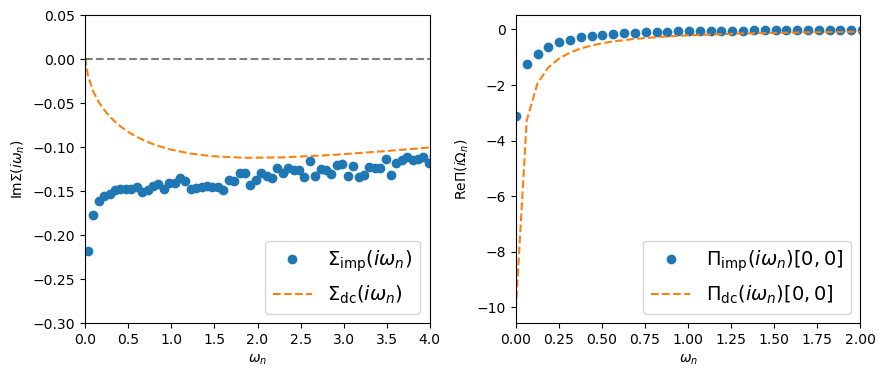

In [11]:
from triqs.plot.mpl_interface import oplot, plt
from h5 import HDFArchive

# Read pre-computed double counting contributions 
with HDFArchive("data/coqui/nio/555/results_dc.h5", 'r') as ar:
    Vhf_dc = ar["Vhf_dc"]
    Sigma_dc_iw = ar["Sigma_dc_iw"]
    ir_iw_mesh_f = ar["iw_mesh_fermion"]
    Pi_dc_iw = ar["Pi_dc_iw"]
    ir_iw_mesh_b = ar["iw_mesh_boson"]

fig, ax = plt.subplots(1,2, figsize=(10,4))

# === (A) Self-energy: impurity vs. double counting ===
# TODO 1: Plot the impurity self-energy at MLWF indices a=b=0 (imaginary part)
# Hint: use `oplot` on Σ_imp from the solver results in 3.2,
ax[0].oplot(Res.Sigma_dynamic['up_0'].imag, 'o', label="$\Sigma_{\mathrm{imp}}(i\omega_n)$")

# Double counting self-energy from local GW at MLWF indices a=b=0
ax[0].plot(ir_iw_mesh_f, Sigma_dc_iw[:,0,0,0].imag, linestyle='--', label="$\Sigma_{\mathrm{dc}}(i\omega_n)$")

ax[0].axhline(y=0, color='black', linestyle='--', alpha=0.5) 
ax[0].set_ylabel(r'Im$\Sigma(i\omega_{n})$')
ax[0].set_xlim(0,4)
ax[0].set_ylim(-0.3,0.05)
ax[0].legend(loc=4, fontsize=14)

# === (B) Polarizability: impurity vs. double counting ===
# TODO 2: Plot the impurity polarizability at MLWF indices a=b=c=d=0 (real part)
# Hint: use `oplot` on Π_imp from the solver results
ax[1].oplot(Res.Pi_iw[0,0,0,0].real, 'o', label="$\Pi_{\mathrm{imp}}(i\omega_n)[0,0]$");

# Double counting polarizability from local RPA at MLWF indices a=b=c=d=0 
ax[1].plot(ir_iw_mesh_b, Pi_dc_iw[:,0,0,0,0].real, linestyle='--', label="$\Pi_{\mathrm{dc}}(i\omega_n)[0,0]$");

ax[1].set_ylabel(r'Re$\Pi(i\Omega_{n})$')
ax[1].set_xlim(0,2.0)
ax[1].legend(loc=4, fontsize=14)
plt.subplots_adjust(wspace=0.25)
#plt.show()
